# Assignment 7: **Convolutional Neural Networks**

# Part 4: U-Net's

## Loading data
First, we start by loading the training data set, which consist of 999 images of 256x256 pixels and 3 channels (R,G,B) and their corresponding road mask. This road mask has been obtained by thresholding the Google Maps background that corresponds to the satellit image. In this thresholding step all white pixels in the Google Maps background are converted to a road masks.

```
# This is formatted as code
```

 

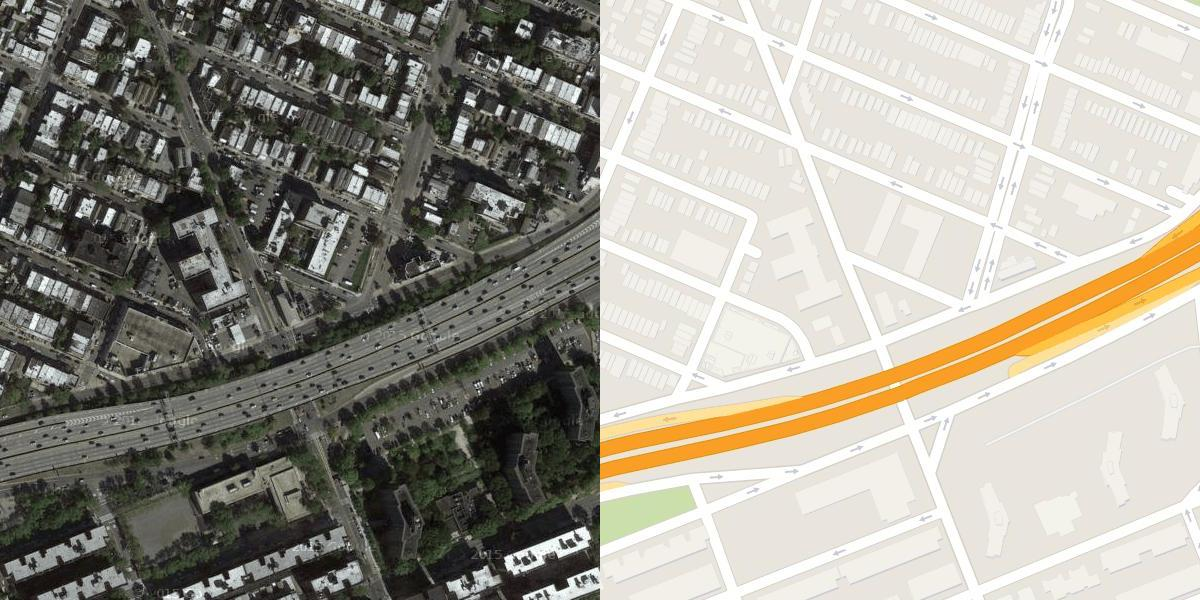

In [ ]:
# Load the compressed training data set
file = h5py.File('Dataset_train.h5', 'r')
# Get the images
imgs_train = file.get('images')
# Get the road labels
imgs_mask_train = file.get('masks')
imgs_train = np.array(imgs_train)
imgs_mask_train = np.array(imgs_mask_train)

imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train /= 255  # scale masks to [0, 1]

Now let's plot a random image and corresponding mask


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

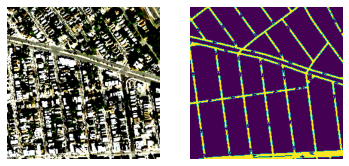

In [ ]:
plt.subplot(121)
plt.imshow(imgs_train[5,:,:,:]) 
plt.axis('off')
plt.subplot(122)
plt.imshow(imgs_mask_train[5,:,:,0]) 
plt.axis('off')

## The U-Net classifier

Before using the U-Net, we first need to define its architecture, which follows a similar approach as the earlier CNN's but now includes the upsampling layers. To do so, we do not use a Sequential model, but build our own model, where each of the layers uses the input of the previous layer

In [ ]:
# Load the necessary packages
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
from keras import backend as keras

### Define the U-Net architecture

In [ ]:
# Define the U-Net model
def unet(input_size = (256, 256, 3)):
    inputs = Input(input_size)

    # Convolution 1
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(inputs)

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(conv1)
    
    # Pooling 1
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Convolution 2
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv2)
    
    # Pooling 2
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Convolution 3
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv3)
    # Pooling 3
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Convolution 4
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv4)
    # Dropout
    drop4 = Dropout(0.5)(conv4)
    
    # Pooling 4
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Convolution 5
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(pool4)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(conv5)
    # Dropout
    drop5 = Dropout(0.5)(conv5)

    # Upward Convolution 6
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(drop5))
    
    # Here we copy the input from the upward convolution and contraction path
    merge6 = concatenate([drop4,up6])
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge6)
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv6)

    # Upward Convolution 7
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv6))
    
    # Here we copy the input from the upward convolution and contraction path
    merge7 = concatenate([conv3,up7])
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge7)
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'
                                                )(conv7)

    # Upward Convolution 8
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv7))
    
    # Here we copy the input from the upward convolution and contraction path
    merge8 = concatenate([conv2,up8])
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge8)
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv8)
    # Upward Convolution 9
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',
                                             kernel_initializer = 'he_normal'
                                             )(UpSampling2D(size = (2,2))(conv8))
    
    # Here we copy the input from the upward convolution and contraction path
    merge9 = concatenate([conv1,up9])
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(merge9)
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv9)
    
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
# Initiate the U-Net model
model = unet()

# Show the model architecture
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_90[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_91[0][0]                  
______________________________________________________________________________________

Now let's define a checkpoint function that allows us to save the weights

In [ ]:
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

### Fit the U-Net model
Fit the model to the training data. Notice that this is again very similar to the CNN's, we only do not use the fixed validation_data, but use the validation_split (i.e., Fraction of the training data to be used as validation data).

In [ ]:
history =  model.fit(imgs_train, imgs_mask_train, batch_size=20, epochs=20, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint])

It can take relatively long before obtaining a good accuracy on the U-Net. Therefore, it is important to save the weights with the `model_checkpoint` function, so we can later load and re-use them.

### Test performance
Let's test the performance on the test data set, which we also need to load:

In [ ]:
# Load data
file = h5py.File('Dataset_test.h5', 'r')
# get images
imgs_test = file.get('images')
# get labels
imgs_mask_test = file.get('masks')
imgs_test = np.array(imgs_test)
imgs_mask_test = np.array(imgs_mask_test).astype('float32')
imgs_test = imgs_test.astype('float32')
# normalize
imgs_test -= mean
imgs_test /= std
imgs_mask_test /= 255


Load saved weights:

In [ ]:
# Load saved weights (can also be used when returning to model later)
model.load_weights('weights.h5')

Predict labels on test data

In [ ]:
# Predicting label on test data
out_mask_test = model.predict(imgs_test, verbose=1)

4/4 [==============================] - 4s 981ms/step


Plot the results:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


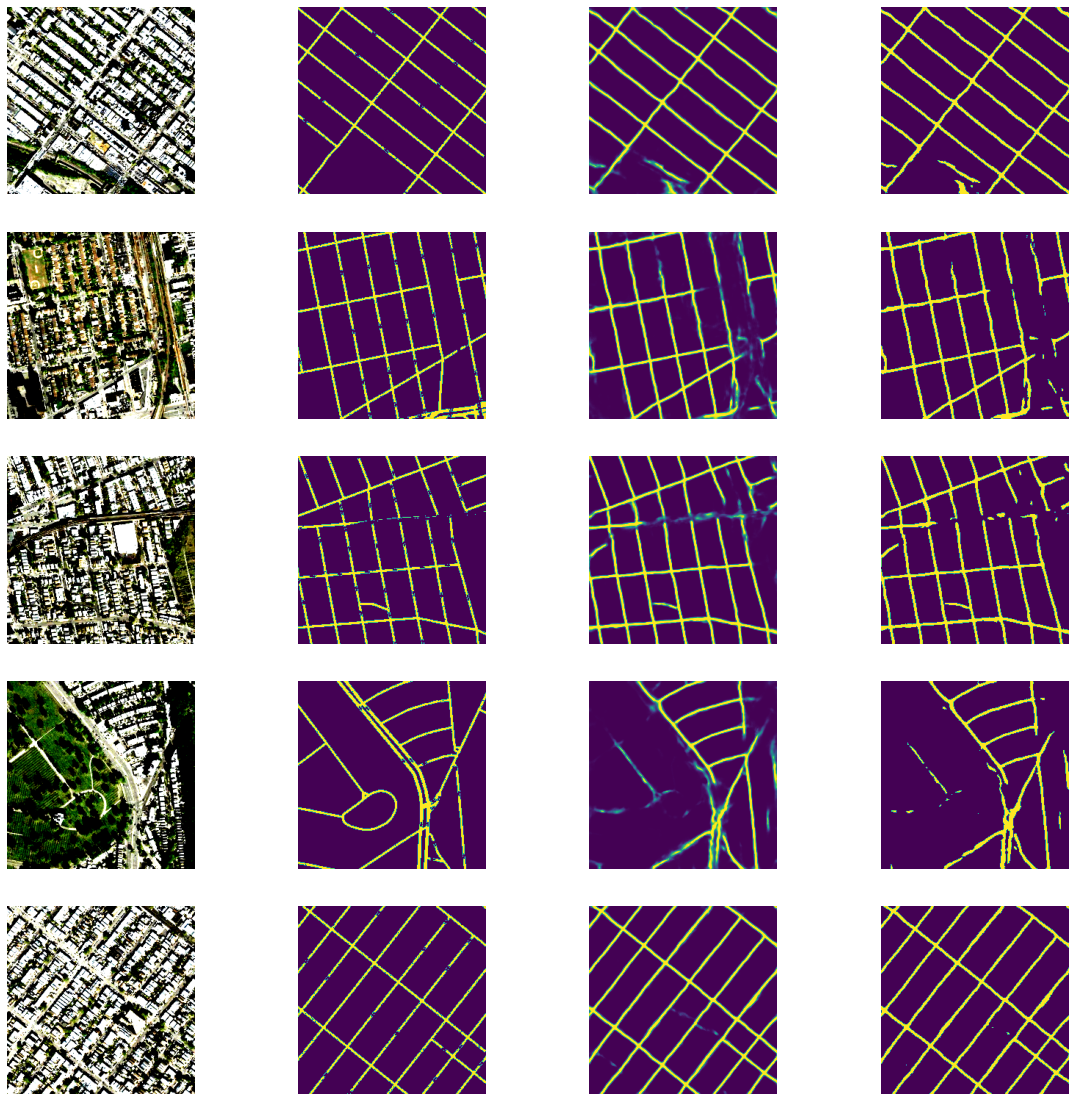

In [ ]:
plt.figure(figsize=(20,20))
for i in range(5):
  # Plotting the input image
  plt.subplot(5, 4, i*4+1)
  plt.imshow(imgs_test[i,:,:,:],vmin=0,vmax=255)
  plt.axis('off')
  # Plotting the input labels
  plt.subplot(5, 4, i*4+2)
  plt.imshow(imgs_mask_test[i,:,:,0],vmin=0,vmax=1)
  plt.axis('off')
  # Plotting the output classifier
  plt.subplot(5, 4, i*4+3)
  plt.imshow(out_mask_test[i,:,:,0])
  plt.axis('off')
  # Plotting the output rescaled by thresholding output
  plt.subplot(5, 4, i*4+4)
  plt.imshow(out_mask_test[i,:,:,0]>0.3)
  plt.axis('off')

## Question 4: Applying and understanding U-Nets

Apply the U-Net architecture to the entire training set and increase the learning time (epochs) to improve performance.

Plot the model performance for both the training and testing.

Plot the input image and label vs. the U-Net trained label and identify discuss the performance. Identify cases where the model performs poorly and well, respectively, at identifying the roads. Explain why this is the case.

In [ ]:
#loading the entire training set
file_q4 = h5py.File('Dataset_train.h5', 'r')
#list(file_q4) - output is ['images', 'masks']
train_images_q4 = file_q4.get('images')
# get labels
train_masks_q4 = file_q4.get('masks')
train_images_q4 = np.array(train_images_q4)
train_masks_q4 = np.array(train_masks_q4).astype('float32')
train_images_q4 = train_images_q4.astype('float32')
# normalize
train_images_q4 -= mean
train_images_q4 /= std
train_masks_q4 /= 255

### Fitting the U-Net model to the training data

In [ ]:
#adding a different model checkpoint for q4. same code as given in the assignment, just saving it to a new variable to avoid confusion
model_checkpoint_q4 = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

In [ ]:
#using the U-Net architecture provided earlier for Question 4
history_train_q4 =  model.fit(train_images_q4, train_masks_q4, batch_size=20, epochs=30, verbose=1, shuffle=True, validation_split=0.2,
                              callbacks=[model_checkpoint_q4])

Epoch 1/30
40/40 [==============================] - 122s 3s/step - loss: 0.0924 - accuracy: 0.9624 - val_loss: 0.1248 - val_accuracy: 0.9548
Epoch 2/30
40/40 [==============================] - 122s 3s/step - loss: 0.0883 - accuracy: 0.9640 - val_loss: 0.1246 - val_accuracy: 0.9558
Epoch 3/30
40/40 [==============================] - 118s 3s/step - loss: 0.0829 - accuracy: 0.9666 - val_loss: 0.1279 - val_accuracy: 0.9569
Epoch 4/30
40/40 [==============================] - 122s 3s/step - loss: 0.0809 - accuracy: 0.9676 - val_loss: 0.1241 - val_accuracy: 0.9567
Epoch 5/30
40/40 [==============================] - 118s 3s/step - loss: 0.0789 - accuracy: 0.9686 - val_loss: 0.1258 - val_accuracy: 0.9570
Epoch 6/30
40/40 [==============================] - 118s 3s/step - loss: 0.0772 - accuracy: 0.9694 - val_loss: 0.1272 - val_accuracy: 0.9569
Epoch 7/30
40/40 [==============================] - 118s 3s/step - loss: 0.0759 - accuracy: 0.9701 - val_loss: 0.1266 - val_accuracy: 0.9568
Epoch 8/30
40

AttributeError: ignored

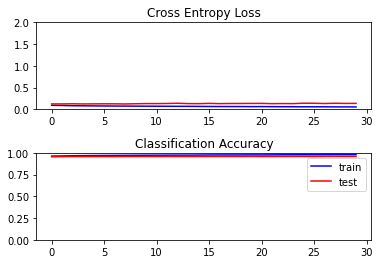

In [ ]:
#plotting performance of u-net for training and testing data
# plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history_train_q4.history['loss'], color='blue', label='train')
plt.plot(history_train_q4.history['val_loss'], color='red', label='test')
plt.ylim(0, 2)
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history_train_q4.history['accuracy'], color='blue', label='train')
plt.plot(history_train_q4.history['val_accuracy'], color='red', label='test')
plt.ylim(0, 1)
# add legend
plt.legend()
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


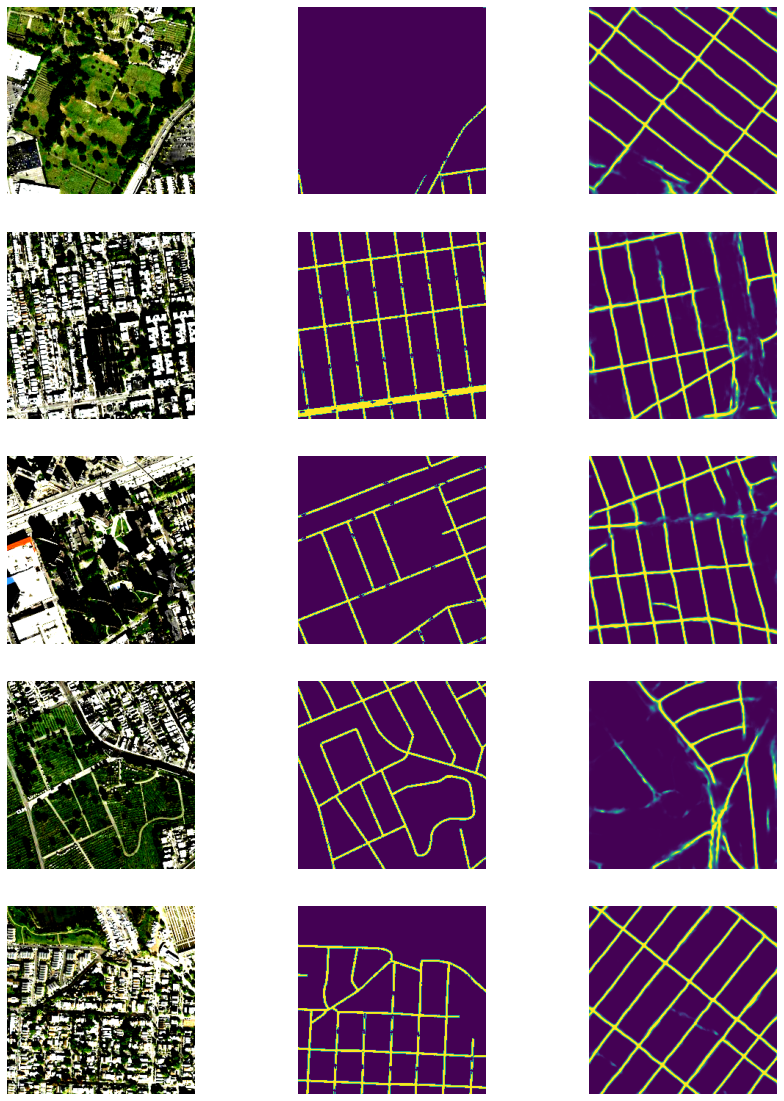

In [ ]:
# Plotting the input image
plt.figure(figsize=(20,20))
for i in range(5):
  plt.subplot(5, 4, i*4+1)
  plt.imshow(train_images_q4[i,:,:,:],vmin=0,vmax=255)
  plt.axis('off')
  # Plotting the input labels
  plt.subplot(5, 4, i*4+2)
  plt.imshow(train_masks_q4[i,:,:,0],vmin=0,vmax=1)
  plt.axis('off')
  # Plotting the output classifier
  plt.subplot(5, 4, i*4+3)
  plt.imshow(out_mask_test[i,:,:,0])
  plt.axis('off')

As we can see from the plots of the images, U-Net tends to work well if the roads are (fairly) unobstructed or demarcated clearly. It tends to struggle when there are a lot of buildings or other objects near the road. If there is a lot of flat land near the roads, like meadows, yards, lawns, etc. it tends to adapt to that fairly quickly and is able to show the roads clearly. Also if the roads have uniform color (of the asphalt) that also makes it easier for U-Net to identify them.